In [191]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import stats



import seaborn as sns
from sklearn import metrics, datasets
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


In [192]:
df = pd.read_csv("/Users/ik/QMinersHackathon42/data/features_many.csv")
df = df[df["y_draw"] == 0]

In [193]:
df.drop(columns = ["Season", "Date", "y_draw", "elo_p_h", "market_type", "y_away_win"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6806 entries, 0 to 7395
Data columns (total 91 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   orig_index                   6806 non-null   int64  
 1   HID                          6806 non-null   int64  
 2   AID                          6806 non-null   int64  
 3   y_home_win                   6806 non-null   int64  
 4   oddsH                        6806 non-null   float64
 5   oddsA                        6806 non-null   float64
 6   elo_h                        6806 non-null   float64
 7   elo_a                        6806 non-null   float64
 8   elo_diff                     6806 non-null   float64
 9   pts_pg_h                     6806 non-null   float64
 10  pts_pg_a                     6806 non-null   float64
 11  gd_pg_h                      6806 non-null   float64
 12  gd_pg_a                      6806 non-null   float64
 13  games_season_h         

In [194]:
bookmaker_odds_H = df["oddsH"].values  # numpy array
bookmaker_odds_A = df["oddsA"].values 
start_idx = int(np.floor(len(bookmaker_odds_H) * 0.75))  # integer start index
bookmaker_odds_H = bookmaker_odds_H[start_idx:]
bookmaker_odds_A = bookmaker_odds_A[start_idx:]  # slice from 25% to end

print(len(bookmaker_odds_H))
print(bookmaker_odds_H)

1702
[1.31 1.4  1.6  ... 1.73 1.43 1.52]


In [195]:
df = df.replace(np.nan,0)
df["Bookmaker_prob"] = (1/df["oddsH"])/(1/df["oddsH"]  + 1/df["oddsA"])
#df.drop(columns = ["oddsH", "oddsA"], inplace=True)
data = df.drop(columns=[ "y_home_win", "Bookmaker_prob"]).values
target = df["y_home_win"].values
bookmaker_prob = df["Bookmaker_prob"].values

scaler = StandardScaler()

random_seed = 42

print(len(bookmaker_prob))
print(len(data))
Xtrain, Xval, ytrain_data, yval_data, bookmaker_prob_train, bookmaker_prob_val_data = train_test_split(
    data, target, bookmaker_prob, test_size=0.25, shuffle=False)
print(len(Xval))
##
Xtrain_data = scaler.fit_transform(Xtrain)
Xval_data = scaler.transform(Xval)

6806
6806
1702


In [196]:
X_train = torch.tensor(Xtrain_data, dtype=torch.float32)
bookmaker_prob_train = torch.tensor(bookmaker_prob_train, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(ytrain_data, dtype=torch.float32).unsqueeze(1)



train_dataset = TensorDataset(X_train, bookmaker_prob_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False) 

In [197]:
import torch.nn.functional as F

class ProbabilityEstimatorNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)  # Single output neuron

    # Xavier/Glorot initialization for hidden layers
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        
        # Small random init for output layer
        nn.init.uniform_(self.output.weight, -0.1, 0.1)
        nn.init.zeros_(self.output.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)  # Outputs probabilities in [0,1]
        return x

import torch

def decorrelation_loss(outputs, bookmaker_prob, lambda_decorr):
    outputs = outputs.view(-1)
    bookmaker_prob = bookmaker_prob.view(-1)
    cov = torch.mean((outputs - outputs.mean()) * (bookmaker_prob - bookmaker_prob.mean()))
    loss = lambda_decorr * cov**2
    return loss

"""def decorrelation_loss(outputs, bookmaker_prob, lambda_decorr):
    outputs = outputs.view(-1)
    bookmaker_prob = bookmaker_prob.view(-1)
    loss = lambda_decorr * torch.sum((outputs - bookmaker_prob).pow(2)) / outputs.size(0)
    return loss"""

def l2_regularization(model, lambda_):
    # Sum of squared weights (L2 norm), excluding biases
    l2_norm = sum(
        torch.sum(param ** 2) 
        for param in model.parameters() 
        if param.requires_grad and param.dim() > 1
    )
    return lambda_ * l2_norm
# in training loop:
# outputs = model(X_batch)
# loss = criterion(outputs, y_batch)
# reg = l2_regularization(model, lambda_)
# total_loss = loss + reg
# total_loss.backward()



In [198]:
# Suppose X_train, y_train, bookmaker_probs_train are your training data tensors
# X_train: (num_samples, feature_dim), y_train: (num_samples, 1), bookmaker_probs_train: (num_samples,)
# Wrap in Dataset and DataLoader
feature_dim = data.shape[1]
model = ProbabilityEstimatorNN(feature_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


criterion = nn.BCEWithLogitsLoss()

num_samples_train = X_train.shape[0]


# Initialize model, optimizer


# Hyperparameters for loss

lambda_ = 0.01
lambda_decorr = 0.3
epochs = 100


# Training loop
def train(model, optimizer, criterion, num_samples_train, lambda_decorr, epochs, train_loader, lambda_):
    
    for epoch in range(epochs):
        print(epoch)
        total_loss = 0
        for X_batch, bookmaker_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch) 
            #print("outputs min/max:", outputs.min().item(), outputs.max().item()) #debugging
            loss = criterion(outputs, y_batch) + decorrelation_loss(bookmaker_batch, outputs,lambda_decorr) + l2_regularization(model, lambda_)
            loss.backward() 
            """for name, param in model.named_parameters():
                if param.grad is not None:
                    print(name, param.grad.norm().item())"""          
             # Backpropagation
            optimizer.step()           # Update parameters)
            total_loss += loss.item() * X_batch.size(0)
        avg_loss = total_loss / len(train_loader.dataset)


    return avg_loss

In [199]:
X_val = torch.tensor(Xval_data, dtype=torch.float32)
bookmaker_prob_val = torch.tensor(bookmaker_prob_val_data, dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(yval_data, dtype=torch.float32).unsqueeze(1)

val_dataset = TensorDataset(X_val, bookmaker_prob_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [200]:
num_samples_val = X_val.shape[0]

def predict(model, criterion, val_loader):
    all_predictions = []
    num_samples = 0
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch, bookmaker_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch) #- (1/num_samples_val)*decorrel_weight*decorellation(bookmaker_batch, outputs)
            batch_size = X_batch.size(0)
            total_loss += loss.item() * batch_size
            num_samples += batch_size
            probs = torch.sigmoid(outputs).view(-1).cpu()
            all_predictions.append(probs)

    avg_loss = total_loss / num_samples
    #print(f"Validation Loss: {avg_loss:.4f}")
    flat_array = torch.cat(all_predictions).numpy()
    mse = mean_squared_error(yval_data, flat_array)
    r2 = r2_score(yval_data, flat_array)

    #print("MSE:", mse)
    #print("R2:", r2)
    return avg_loss, flat_array, mse, r2

In [201]:
def accuracy(flat_array, sensitivity):
    adjusted = np.full_like(flat_array, 0.5)  # Initialize with 0.5

    mask_high = flat_array > (0.5 + sensitivity)
    mask_low = flat_array < (0.5 - sensitivity)

    adjusted[mask_high] = 1
    adjusted[mask_low] = 0

    adjusted = adjusted.reshape(-1)

    acc = (adjusted == yval_data).mean()

    print(f"Validation accuracy of normalized model: {acc:.4f}")
    print(np.unique(yval_data))  
    print("acc on making a guess:", acc*len(adjusted)/np.sum(adjusted != 0.5))
    acc_with_making_a_guess = acc*len(adjusted)/np.sum(adjusted != 0.5)
    volatility = np.sum(adjusted != 0.5)
    return acc, acc_with_making_a_guess, volatility

In [202]:


# Hyperparameters for loss
epochs = 4
lambda_decorr = 0.3
lambda_ = 0.02

acc_coeff = 0.03
avg_train_loss_set = []
val_loss_set = []
array_for_outcomes = np.array([])
mse_arr = []
r2_arr = []
x_axis = []
acc_arr = []
acc_with_making_a_guess_arr = []
volatility_arr = []
 # Training loop

feature_dim = data.shape[1]
model = ProbabilityEstimatorNN(feature_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

num_samples_train = X_train.shape[0]

avg_train_loss_set.append(train(model, optimizer, criterion, num_samples_train, lambda_decorr, epochs, train_loader, lambda_))

print(avg_train_loss_set)
val_loss, flat_array, mse, r2 = predict(model, criterion, val_loader)
acc, acc_with_making_a_guess, volatility = accuracy(flat_array, acc_coeff )
val_loss_set.append(val_loss)
#array_for_outcomes = np.vstack([flat_array, array_for_outcomes])

mse_arr.append(mse)
r2_arr.append(r2)
x_axis.append(epochs)

volatility_arr.append(volatility)
acc_with_making_a_guess_arr.append(acc_with_making_a_guess)
acc_arr.append(acc)

print("MSE arr:", mse_arr)
print("R2 arr:", r2_arr)


0
1
2
3
[0.673096349994217]
Validation accuracy of normalized model: 0.6099
[0 1]
acc on making a guess: 0.6098707403055229
MSE arr: [0.23282915353775024]
R2 arr: [0.021432042121887207]


In [203]:
print(flat_array)

[0.6297768  0.6002415  0.58121234 ... 0.5771532  0.6128268  0.60774225]


In [204]:
from scipy.optimize import minimize


def betting(outcome, sens, bookmaker_odds_H, bookmaker_odds_A, wealth):
    """
    Maximize Sharpe ratio given model probabilities and bookmaker odds.
    """
    
    # -----------------------------
    # 1. CLASSIFICATION
    # -----------------------------
    def classify_probabilities(outcome, sens):
        result = {}
        for i, p in enumerate(outcome):
            if p > 0.5 + sens:
                result[i] = ("H", (p,bookmaker_odds_H[i]))
            elif p < 0.5 - sens:
                result[i] = ("A", (1 - p, bookmaker_odds_A[i]))
            else:
                result[i] = ("D", 0.0)
        return result

    classified = classify_probabilities(outcome, sens)

    # Extract only usable probabilities (H/A bets)

    # -----------------------------
    # 2. EXPECTED RETURN & VARIANCE
    # -----------------------------
    #exp_ret = np.maximum(probs * bookmaker_odds - 1,0) 
    indices = list(classified.keys())
    labels = []
    p_list = []
    odds_list = []

    for i, (label, info) in classified.items():
        labels.append(label)
        if label == "D":
            p_list.append(0.0)
            odds_list.append(0.0)
        else:
            p, o = info   # info = (p, odds)
            p_list.append(p)
            odds_list.append(o)
    #print(odds_list)
    probs = np.array(p_list)        # shape (n,)
    odds  = np.array(odds_list)     # shape (n,)
    labels = np.array(labels) 

    exp_ret = probs*odds - 1 # μ_i = p_i * o_i - 1

    var_ret = probs * (1 - probs) * (odds ** 2) + 1e-8 
        # μ_i = p_i * o_i - 1        
         # σ_i² = p(1-p)o²
 
    # -----------------------------
    # 3. INITIAL GUESS
    # -----------------------------
    
    b0 = np.clip(probs, 1e-3, wealth)  # start with 0 bets
    

    # -----------------------------
    # 4. BOUNDS: zero-prob → force no bet
    # -----------------------------
    bounds = []
    for p in probs:
        if p == 0:
            bounds.append((0, 0))           # lock bet = 0
        else:
            bounds.append((0, wealth))      # normal range

    # -----------------------------
    # 5. Constraint: sum(bets) ≤ wealth
    # -----------------------------
    constraints = [
        {'type': 'ineq', 'fun': lambda b: wealth - np.sum(b)}
    ]

    # -----------------------------
    # 6. Sharpe ratio (negative for minimizer)
    # -----------------------------
    def sharpe_negative(b, exp_ret, var_ret):
        expected_return = b @ exp_ret
        variance = np.sum((b ** 2) * var_ret)

        #print("expected_return:", expected_return, "shape:", np.shape(expected_return))
        #print("variance:", variance, "shape:", np.shape(variance))

        if np.isscalar(expected_return) == False or np.isscalar(variance) == False:
            raise ValueError("Expected return and variance must be scalars.")

        if variance <= 0:
            return np.inf

        return -(expected_return / np.sqrt(variance))
    # -----------------------------
    # 7. Optimization
    # -----------------------------
    result = minimize(
        fun=sharpe_negative,
        x0=b0,
        args=(exp_ret, var_ret),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    optimal_bets = result.x

    # -----------------------------
    # 8. Attach to dictionary
    # -----------------------------
    merged = {}
    for k, i in enumerate(indices):
        label, info = classified[i]
        merged[i] = {
            "label": label,
            "prob": info,
            "bet": float(optimal_bets[k])
        }

    return merged, -result.fun


In [205]:
wealth = 1.0
bets, max_sharpe = betting(flat_array, 0.18, bookmaker_odds_H, bookmaker_odds_A, wealth)
for i in range(len(bets)):
    if bets[i]["label"] == "A":
        print("yes")
    if bets[i]["bet"] != 0:
        print(f"Bet {bets[i]['bet']:.4f} on match {i+1}")
#it wont print anything



Bet 0.0000 on match 213
Bet 0.0000 on match 287
Bet 0.0000 on match 292
Bet 0.0000 on match 684
Bet 0.0000 on match 833
Bet 0.0000 on match 848
Bet 0.0000 on match 863
Bet 0.0000 on match 894
Bet 0.0000 on match 1079
Bet 0.0000 on match 1082
Bet 0.0000 on match 1094
Bet 0.0000 on match 1098
Bet 0.0000 on match 1107
Bet 0.0000 on match 1117
Bet 0.0000 on match 1127
Bet 0.0000 on match 1141
Bet 0.0000 on match 1144
Bet 0.0000 on match 1176
Bet 0.0000 on match 1189
Bet 0.0000 on match 1198
Bet 0.0000 on match 1235
Bet 0.0000 on match 1271
Bet 0.0000 on match 1275
Bet 0.0000 on match 1295
Bet 0.0000 on match 1297
Bet 0.0000 on match 1304
Bet 0.9221 on match 1306
Bet 0.0000 on match 1323
Bet 0.0000 on match 1346
Bet 0.0000 on match 1380
Bet 0.0000 on match 1569
Bet 0.0000 on match 1592
Bet 0.0000 on match 1600
Bet 0.0000 on match 1644
Bet 0.0000 on match 1677
Bet 0.0000 on match 1679
Bet 0.0000 on match 1694
Bet 0.0000 on match 1696


In [206]:
wealth = 1.0
for i in range(len(yval_data)):
    if bets[i]["bet"] > 0.001:
        if yval_data[i]==1:
            wealth += bets[i]["bet"]* (bookmaker_odds_H[i]-1)
        else:
            wealth -= bets[i]["bet"]

print("Final wealth:", wealth)

Final wealth: 1.1106494815332377


In [207]:
#second test 

wealth = 1.0

tenths_flat = np.array_split(flat_array, 10) 
tenths_yval = np.array_split(yval_data, 10)
tenths_bookmaker_odds_H = np.array_split(bookmaker_odds_H, 10)
tenths_bookmaker_odds_A = np.array_split(bookmaker_odds_A, 10)

for t in range(10):
    if wealth < 0:
        print("Wealth depleted, stopping betting.")
        break
    bets, max_sharpe = betting(tenths_flat[t], 0.18, tenths_bookmaker_odds_H[t], tenths_bookmaker_odds_A[t], wealth)
    #zde akorát bacha, kdyby někdy vyšlo něco pro A tým, ale to nejspíš není problém -> kontrolovat label
    for i in range(len(bets)):
        """if bets[i]["label"] == "A":
            print("yes")
        if bets[i]["bet"] > 0.001:
            print(f"!!Bet {bets[i]['bet']:.4f} on match {i+1}")"""

        if bets[i]["bet"] > 0.001:
            if tenths_yval[t][i]==1:
                wealth += bets[i]["bet"]* (tenths_bookmaker_odds_H[t][i]-1)
            else:
                wealth -= bets[i]["bet"]

    print("Final wealth:", wealth)

Final wealth: 1.2784686756168337
Final wealth: 0.001770810247186505
Final wealth: 4.1744385725905886e-13
Final wealth: 4.1744385725905886e-13
Final wealth: 4.1744385725905886e-13
Final wealth: 4.1744385725905886e-13
Final wealth: 4.1744385725905886e-13
Final wealth: 4.1744385725905886e-13
Final wealth: 4.1744385725905886e-13
Final wealth: 4.1744385725905886e-13


In [208]:
x_axis = []
wealth_arr = []
for sens in range(30):
    print("--------- new sens")
    x_axis.append(sens)
    wealth = 1.0
    for t in range(10):
        sumation = 0
        if wealth < 0:
            print("Wealth depleted, stopping betting.")
            break
        bets, max_sharpe = betting(tenths_flat[t], 0.03 + sens*0.01, tenths_bookmaker_odds_H[t], tenths_bookmaker_odds_A[t], wealth)
        
        for i in range(len(bets)):
            if bets[i]["bet"] > 0.001:
                    sumation += 1
                    if tenths_yval[t][i]==1:
                        wealth += bets[i]["bet"]* (tenths_bookmaker_odds_H[t][i]-1)
                    else:
                        wealth -= bets[i]["bet"]
        print("nb of place bets", sumation)

    print("Final wealth:", wealth, "sens", sens)
    wealth_arr.append(wealth)

--------- new sens
nb of place bets 3
nb of place bets 4
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
Final wealth: 9.381384558082573e-15 sens 0
--------- new sens
nb of place bets 3
nb of place bets 4
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
Final wealth: 9.381384558082573e-15 sens 1
--------- new sens
nb of place bets 3
nb of place bets 4
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
Final wealth: 9.381384558082573e-15 sens 2
--------- new sens
nb of place bets 2
nb of place bets 3
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
Final wealth: 0.0012558902016854834

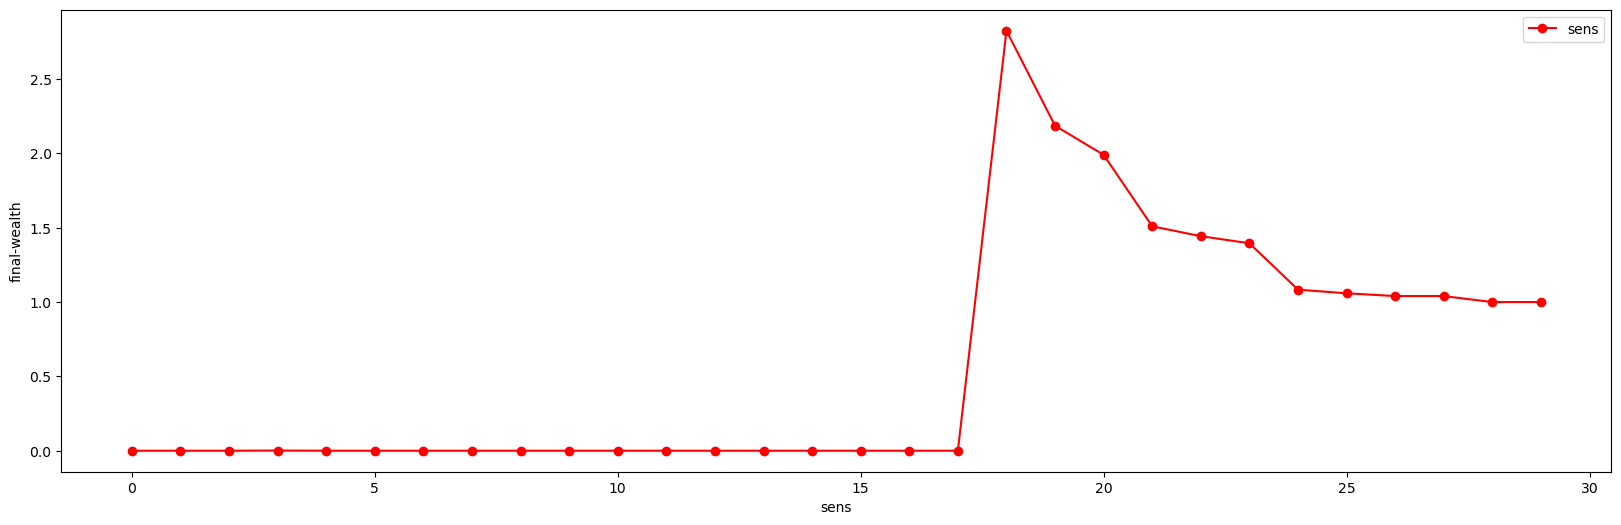

In [209]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,6))
plt.plot(x_axis, wealth_arr,'or-') #o: body, r: barva, -: spojení bodů linkou

plt.xlabel('sens')
plt.ylabel('final-wealth')
plt.legend(['sens'])

In [210]:


# Hyperparameters for loss
epochs = 4
lambda_decorr = 0.3
lambda_ = 0.02
wealth_arr = []
acc_coeff = 0.19
avg_train_loss_set = []
val_loss_set = []
array_for_outcomes = np.array([])
mse_arr = []
r2_arr = []
x_axis = []
acc_arr = []
acc_with_making_a_guess_arr = []
volatility_arr = []
 # Training loop

for i in range(10):
    lambda_decorr = 0.1 + i*0.1
    feature_dim = data.shape[1]
    model = ProbabilityEstimatorNN(feature_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

    num_samples_train = X_train.shape[0]

    avg_train_loss_set.append(train(model, optimizer, criterion, num_samples_train, lambda_decorr, epochs, train_loader, lambda_))

    print(avg_train_loss_set)
    val_loss, flat_array, mse, r2 = predict(model, criterion, val_loader)
    acc, acc_with_making_a_guess, volatility = accuracy(flat_array, acc_coeff )
    val_loss_set.append(val_loss)
    #array_for_outcomes = np.vstack([flat_array, array_for_outcomes])

    mse_arr.append(mse)
    r2_arr.append(r2)
    x_axis.append(lambda_decorr)

    volatility_arr.append(volatility)
    acc_with_making_a_guess_arr.append(acc_with_making_a_guess)
    acc_arr.append(acc)

    print("MSE arr:", mse_arr)
    print("R2 arr:", r2_arr)
    print("--------- new sens")
    wealth = 1.0
    for t in range(10):
        sumation = 0
        if wealth < 0:
            print("Wealth depleted, stopping betting.")
            break
        bets, max_sharpe = betting(tenths_flat[t], acc_coeff, tenths_bookmaker_odds_H[t], tenths_bookmaker_odds_A[t], wealth)
        
        for i in range(len(bets)):
            if bets[i]["bet"] > 0.001:
                    sumation += 1
                    if tenths_yval[t][i]==1:
                        wealth += bets[i]["bet"]* (tenths_bookmaker_odds_H[t][i]-1) #it usually wont happen but what if there are book odds for A?
                    else:
                        wealth -= bets[i]["bet"]
        print("nb of place bets", sumation)

    print("Final wealth:", wealth, "sens", sens)
    wealth_arr.append(wealth)



0
1
2
3
[0.6774544127308837]
Validation accuracy of normalized model: 0.0564
[0 1]
acc on making a guess: 0.8
MSE arr: [0.23285920917987823]
R2 arr: [0.021305620670318604]
--------- new sens
nb of place bets 1
nb of place bets 1
nb of place bets 1
nb of place bets 1
nb of place bets 1
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
Final wealth: 0.0 sens 29
0
1
2
3
[0.6774544127308837, 0.6746695947871313]
Validation accuracy of normalized model: 0.0640
[0 1]
acc on making a guess: 0.7956204379562044
MSE arr: [0.23285920917987823, 0.2327660620212555]
R2 arr: [0.021305620670318604, 0.021697163581848145]
--------- new sens
nb of place bets 1
nb of place bets 1
nb of place bets 1
nb of place bets 1
nb of place bets 1
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
nb of place bets 0
Final wealth: 0.0 sens 29
0
1
2
3
[0.6774544127308837, 0.6746695947871313, 0.6749679281793791]
Validation accuracy of normalized model:

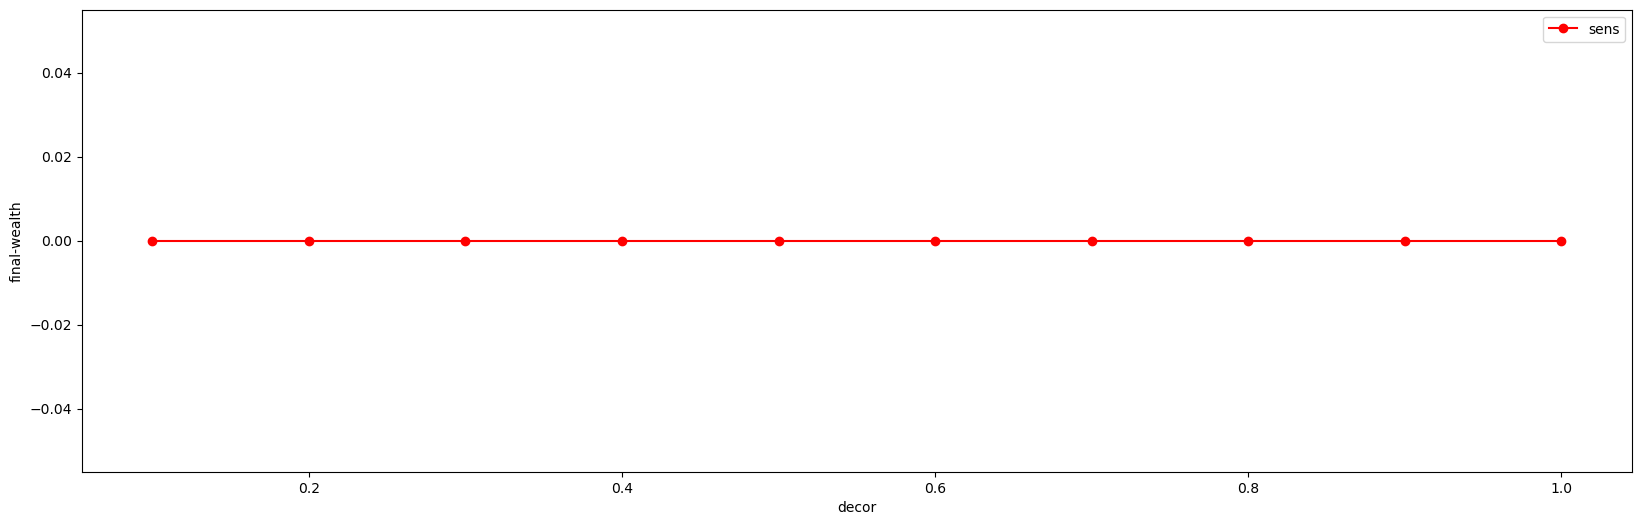

In [211]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,6))
plt.plot(x_axis, wealth_arr,'or-') #o: body, r: barva, -: spojení bodů linkou

plt.xlabel('decor')
plt.ylabel('final-wealth')
plt.legend(['sens'])